### Titanic

* https://www.kaggle.com/c/titanic

In [244]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
p = os.path.join(os.path.dirname('__file__'), '..')
sys.path.append(p)
from common import *

import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Project overview

In [245]:
"""
https://www.kaggle.com/c/titanic/data

Hypothesis (important features)
- Gender
- PClass = Ticket class (proxy for socioeconomic status)
- Age

Other
- Fare
- Embarked
- Name (Dr, Sir)

891 passengers
predict whether they survived or not
"""

'\nhttps://www.kaggle.com/c/titanic/data\n\nHypothesis (important features)\n- Gender\n- PClass = Ticket class (proxy for socioeconomic status)\n- Age\n\nOther\n- Fare\n- Embarked\n- Name (Dr, Sir)\n\n891 passengers\npredict whether they survived or not\n'

### Load Data

In [246]:
DATA_PATH = '/home/bfortuner/.kaggle/competitions/titanic'
TRAIN_PATH = Path(DATA_PATH, 'train.csv')
TEST_PATH = Path(DATA_PATH, 'test.csv')
train = pd.read_csv(TRAIN_PATH)

### Summary Stats

In [247]:
# Columns, dtype, size
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [131]:
# Basic stats - mean, min, max, std, quartiles
train_dset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [132]:
# Unique counts
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [133]:
train_dset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [134]:
# Count null values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Histograms 

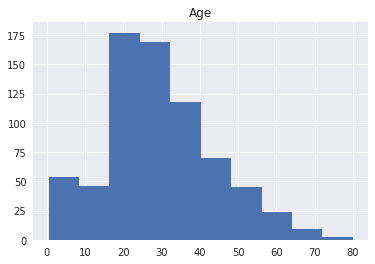

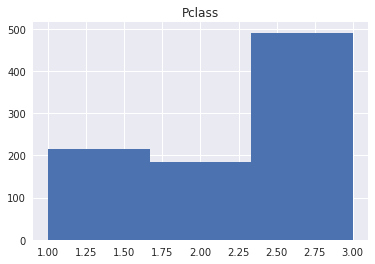

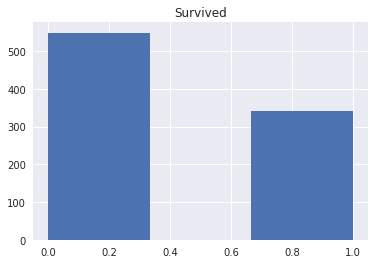

In [135]:
# Numerical
train.hist(column='Age');
train.hist(column='Pclass', bins=3);
train.hist(column='Survived', bins=3);

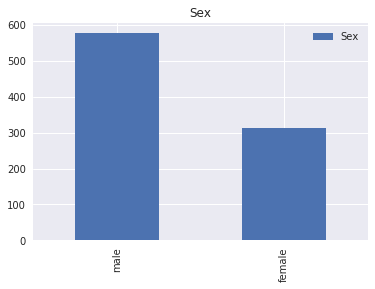

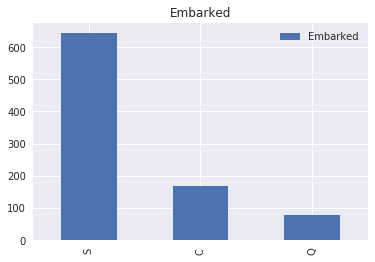

In [136]:
# Strings
train[['Sex']].apply(pd.value_counts).plot(kind='bar', subplots=True);
train[['Embarked']].apply(pd.value_counts).plot(kind='bar', subplots=True);

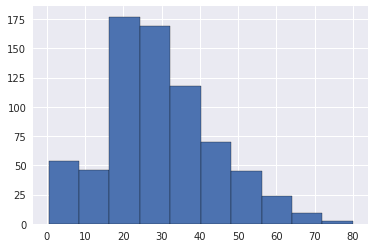

[100 346 188  69  11] [ 0.42  16.336 32.252 48.168 64.084 80.   ]


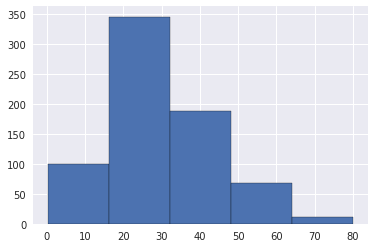

In [237]:
# Histograms with Numpy (more control over bin size)
arr = train[['Age']].dropna().as_matrix()
counts, edges = np.histogram(arr)

fig, ax = plt.subplots()
ax.bar(edges[:-1], counts, width=np.diff(edges), ec="k", align="edge")
plt.show()


# Set number of bins
counts, edges = np.histogram(arr,bins=5)
print(counts, edges)

fig, ax = plt.subplots()
ax.bar(edges[:-1], counts, width=np.diff(edges), ec="k", align="edge")
plt.show()

### Correlation / Covariance

In [137]:
"""
Try to get a sense of patterns/relationship between features and target
1) Covariance matrix
2) Pearson correlation coefficient
""";

In [138]:
# Covariance matrix

### Handle Null Values

In [139]:
"""
Options
------
1) Drop columns with too many null values
2) Drop rows with null values
3) Set Null values to constant placeholder (e.g. -9999999)
    * Binary Features
        -1 for negatives
        0 for missing values
        1 for positives
4) Backfill with Mean, Median, Mode of column
5) Backfill based on similar rows/class labels (clustering, class labels)
6) Time-series = forward / backward fill (fill with previous non-null value)
...

""";

In [189]:
# Drop rows with null values
df = train.copy()
print(df.isnull().sum())

# Drow rows with null values in 'Age' column
df = df.dropna(how='any', subset=['Age'])

# Drop rows with null values in any column
df = df.dropna(how='any')
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [160]:
# Replace with constant
"""
* Binary Features
    -1 for negatives
    0 for missing values
    1 for positives
"""
df = train.copy()
print(df['Cabin'].isnull().sum())
df = df[['Cabin']].fillna(value=9999) 
df['Cabin'].isnull().sum()

687


0

Mode 0    S
dtype: object
Median 28.0
Mean 29.69911764705882
male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
After 0


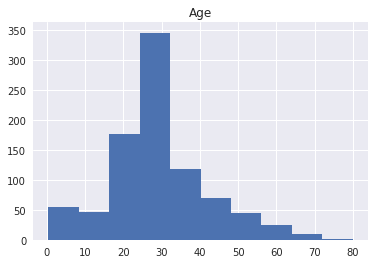

In [181]:
# Fill with most common value

# Mode, median, mean
print("Mode", train['Embarked'].mode())
print("Median", train['Age'].median())
print("Mean", train['Age'].mean())

# Other possibilities
print(train["Sex"].value_counts())
print(train["Embarked"].value_counts())
print(train["Pclass"].value_counts())

# Replace with Median
df = train.copy()
df = df[['Age']].fillna(value=df['Age'].median())
print("After", df['Age'].isnull().sum())
df[['Age']].hist();

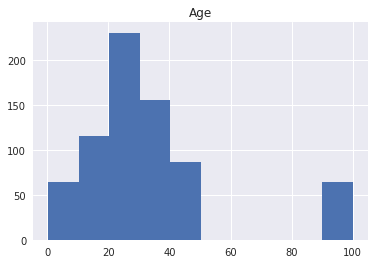

In [250]:
# Conditionally fill values
df = train.copy()
df['Age'] = np.where(df['Age'] > 50, 100, df['Age'])
df[['Age']].hist();

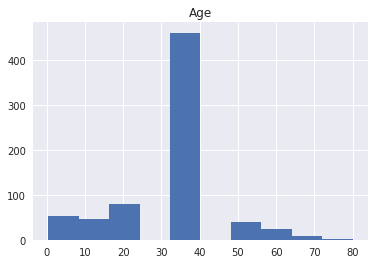

In [251]:
# Conditionally fill with multiple conditions
df = train.copy()
df['Age'] = np.where((df['Age'] > 20) & (df['Age'] < 50), 40, df['Age'])
df[['Age']].hist();

In [254]:
# Fill nulls in multiple columns simultaneously
df = train.copy()
df = df.fillna({
    "Age": 999,
    "Embarked": "C",
    "Cabin": "N"
})
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [192]:
# Bfill/Ffill
# Fill with last/next value in sequence
# Good for time series!

df = train.copy()
df = df[['Age']].fillna(method='bfill')
df = df[['Age']].fillna(method='ffill')
df[['Age']].isnull().sum()

Age    0
dtype: int64

In [255]:
# For our purposes, let's fill with constants
train = train.fillna({
    "Age": 999,
    "Embarked": "C",
    "Cabin": "N"
})
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

### Feature Selection

In [340]:
"""
* Simple features
* Features with high correlation with target
* Features with low correlation with other features

Make sure to include the target label at this stage (before train/test split)
"""

FEATURES = ['Pclass', 'Sex', 'Embarked', 'Survived']
TARGET = 'Survived'
features = train[FEATURES].copy()
features.head()

,Pclass,Sex,Embarked,Survived
0,3,male,S,0
1,1,female,C,1
2,3,female,S,1
3,1,female,S,1
4,3,male,S,0


### Categorical Encoding

* http://pbpython.com/categorical-encoding.html

In [341]:
"""
Converting text values into numbers

Binary = True/False (Male/Female)
    - Convert to 0/1
Nominal = class names (Dog, Cat, Mouse)
    - One-hot encoding
Ordinal = order matters (Low, Medium, High)
    - Label encoding
Interval (1-10, 11-20, ..)
    - ??
Continuous (1.2, 1.5, 1.6, ..)
    - Consider binning and converting to Interval
    - ?? - look at how to do this later
"""

'\nConverting text values into numbers\n\nBinary = True/False (Male/Female)\n    - Convert to 0/1\nNominal = class names (Dog, Cat, Mouse)\n    - One-hot encoding\nOrdinal = order matters (Low, Medium, High)\n    - Label encoding\nInterval (1-10, 11-20, ..)\n    - ??\nContinuous (1.2, 1.5, 1.6, ..)\n    - Consider binning and converting to Interval\n    - ?? - look at how to do this later\n'

In [342]:
# With numpy np.where
df = features.copy()
df['Sex'] = np.where(df['Sex'] == 'male', 0, 1)
df['Embarked'] = np.where(df['Embarked'] == 'male', 0, 1)
df.head()

,Pclass,Sex,Embarked,Survived
0,3,0,1,0
1,1,1,1,1
2,3,1,1,1
3,1,1,1,1
4,3,0,1,0


In [343]:
# With find and replace
df = features.copy()
df.replace({
    "Sex": {
        "male": 0,
        "female": 1
    },
    "Embarked": {
        "S": 0,
        "C": 1,
        "Q": 2
    }
}, inplace=True)
df.head()

,Pclass,Sex,Embarked,Survived
0,3,0,0,0
1,1,1,1,1
2,3,1,0,1
3,1,1,0,1
4,3,0,0,0


In [344]:
# Pandas 'category' codes
"""
Good for ordinal (order matters)
Bad for nominal with many categories
"""
df = features.copy()
df['Embarked'] = df['Embarked'].astype('category')
df['Embarked'] = df['Embarked'].cat.codes
df.head()

,Pclass,Sex,Embarked,Survived
0,3,male,2,0
1,1,female,0,1
2,3,female,2,1
3,1,female,2,1
4,3,male,2,0


In [345]:
# One hot encoding (typically best for all but binary features)
"""
Label encoding (1,2,3,4) has the advantage that it is straightforward but it has the disadvantage that the numeric values can be “misinterpreted” by the algorithms. 

For example, the value of 0 is obviously less than the value of 4 but does that really correspond to the data set in real life? Does a wagon have “4X” more weight in our calculation than the convertible? In this example, I don’t think so.
"""
df = features.copy()
df = pd.get_dummies(df, columns=['Embarked'], prefix=['Emb'])
df.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
0,3,male,0,0,0,1
1,1,female,1,1,0,0
2,3,female,1,0,0,1
3,1,female,1,0,0,1
4,3,male,0,0,0,1


In [346]:
# For our purposes, let's use category codes for male/female and one hot for embarked
features = train[FEATURES].copy()
features = pd.get_dummies(features, columns=['Embarked'], prefix=['Emb'])
features['Sex'] = features['Sex'].astype('category')
features['Sex'] = features['Sex'].cat.codes
features.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
0,3,1,0,0,0,1
1,1,0,1,1,0,0
2,3,0,1,0,0,1
3,1,0,1,0,0,1
4,3,1,0,0,0,1


### Feature Engineering

In [371]:
"""
Simple
------
1) Convert timestamps into Day, Week, Month, Year
2) Combine two features into a new feature
3) Convert continous features into bins
4) Normalization
    - Especially continuous variables with large ranges

Advanced
--------
1) Dimensionality Reduction (PCA, SVD, T-SNE, K-Means)
2) ....
""";

### Train/Test Split

In [367]:
"""
Approaches
    * Split on time
    * Randomly shuffle
    * Balance classes

Split size
    * Train/Val
    * K-Fold
    
Convert to Numpy
""";

In [368]:
# Shuffle (Pandas)
features = features.sample(frac=1)
features.head()

,Pclass,Sex,Survived,Emb_C,Emb_Q,Emb_S
743,3,1,0,0,0,1
495,3,1,0,1,0,0
641,1,0,1,1,0,0
533,3,0,1,1,0,0
710,1,0,1,1,0,0


In [392]:
# Train/Test Split
Y = features[TARGET].as_matrix()

X = features.copy()
X = X.drop(axis=1, labels=[TARGET])
x_columns = X.columns
X = X.as_matrix()

X[:10],Y[:10]

(array([[3, 1, 0, 0, 1],
        [3, 1, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [3, 0, 1, 0, 0],
        [1, 0, 1, 0, 0],
        [3, 0, 0, 0, 1],
        [3, 0, 0, 1, 0],
        [2, 1, 0, 0, 1],
        [3, 1, 0, 0, 1],
        [3, 1, 0, 0, 1]]), array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0]))

In [393]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=42
)

### Simple Baseline

In [394]:
"""
Classification

* Logistic Regression
* Naive Bayes
* Decision Tree 
""";
seed = 42

### Logistic Regression

In [425]:
"""
* Classification algorithm
* Linear regression with Sigmoid() to get probabilities

Pros
* Fast
* Doesn't overfit

Cons
* Underfits
""";

In [434]:
from sklearn.linear_model.logistic import LogisticRegression

model = LogisticRegression(penalty='l2', fit_intercept=True, random_state=seed)
model.fit(X_train,y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.8019662921348315
Test: 0.7262569832402235


In [435]:
# Inspect Coefficients and Intercept
print(x_columns)
model.coef_,model.intercept_

Index(['Pclass', 'Sex', 'Emb_C', 'Emb_Q', 'Emb_S'], dtype='object')


(array([[-0.83290575, -2.57631995,  0.96076418,  0.87443012,  0.505674  ]]),
 array([2.3408683]))

In [436]:
# Predict class labels (0/1)
y_pred = model.predict(X_test)
y_pred[:5]

array([0, 0, 0, 1, 0])

In [437]:
# Predict probabilities
y_prob = model.predict_proba(X_test)
y_prob[:5]

array([[0.6370732 , 0.3629268 ],
       [0.52687239, 0.47312761],
       [0.8652665 , 0.1347335 ],
       [0.11777859, 0.88222141],
       [0.52687239, 0.47312761]])

In [438]:
# Apply custom threshold to probabilities?

In [ ]:
# Visualize?

In [423]:
# Other metrics?

### Naive Bayes

In [426]:
"""
* Classification or Regression (usually classification)

Variations
* Gaussian
* Multinomial

Pros
* Fast
* Doesn't overfit

Cons
* Underfits
""";

In [433]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

model = GaussianNB()
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.7823033707865169
Test: 0.7150837988826816


### Decision Tree

In [432]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    criterion='gini', max_depth=None, 
    min_samples_split=2, random_state=seed)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train 0.8230337078651685
Test 0.7653631284916201


### Advanced Models

In [90]:
"""
SVM
Random Forest
XGBoost
MLP
""";

In [441]:
from sklearn.svm import LinearSVC

model = LinearSVC(penalty='l2', loss='squared_hinge', random_state=seed)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.8019662921348315
Test: 0.7262569832402235


In [450]:
from sklearn.ensemble import RandomForestClassifier

# Why is this the same as the decision tree?
model = RandomForestClassifier(
    n_estimators=10, criterion='gini', 
    max_depth=None, random_state=seed
)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.8230337078651685
Test: 0.7653631284916201


### Cross Validation

### Grid Search

### Resources

* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/